In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.cluster import KMeans


In [60]:
data = pd.read_csv('drugsComTrain_raw.csv')

In [61]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [63]:
data.duplicated().sum()

0

In [64]:
data.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [65]:
data = data.dropna()

In [66]:
data.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [67]:
data.shape

(160398, 7)

In [68]:
data['condition'].value_counts()

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 884, dtype: int64

In [69]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [71]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Clean the reviews
stop_words = set(stopwords.words('english'))

def clean_review(text):
    text = re.sub(r'\W', ' ', text)  
    tokens = word_tokenize(text.lower()) 
    filtered_tokens = [word for word in tokens if word not in stop_words]  
    return ' '.join(filtered_tokens)

data['cleaned_condition'] = data['condition'].apply(clean_review)
data['cleaned_review'] = data['review'].apply(clean_review)



In [72]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_condition,cleaned_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,left ventricular dysfunction,side effect take combination bystolic 5 mg fis...
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,adhd,son halfway fourth week intuniv became concern...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,birth control,used take another oral contraceptive 21 pill c...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,birth control,first time using form birth control 039 glad w...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,opiate dependence,suboxone completely turned life around feel he...


In [73]:
import numpy as np
x = np.array([3, 5, 7])
y = np.array([5, 7, 9])
print(np.hstack((x, y)))


[3 5 7 5 7 9]


In [75]:
# Initialize TF-IDF Vectorizers
tfidf_review = TfidfVectorizer(stop_words='english')
tfidf_condition = TfidfVectorizer(stop_words='english')

# Transform text data to TF-IDF matrices
tfidf_review_matrix = tfidf_review.fit_transform(data['cleaned_review'])
tfidf_condition_matrix = tfidf_condition.fit_transform(data['cleaned_condition'])


In [76]:
combined_text = hstack([tfidf_review_matrix, tfidf_condition_matrix])


In [77]:
numerical_features = data[['rating', 'usefulCount']]


In [79]:
combined_feature = hstack([combined_text, numerical_features])


In [80]:
wcss = []
k_range = range(1, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_feature)
    wcss.append(kmeans.inertia_)

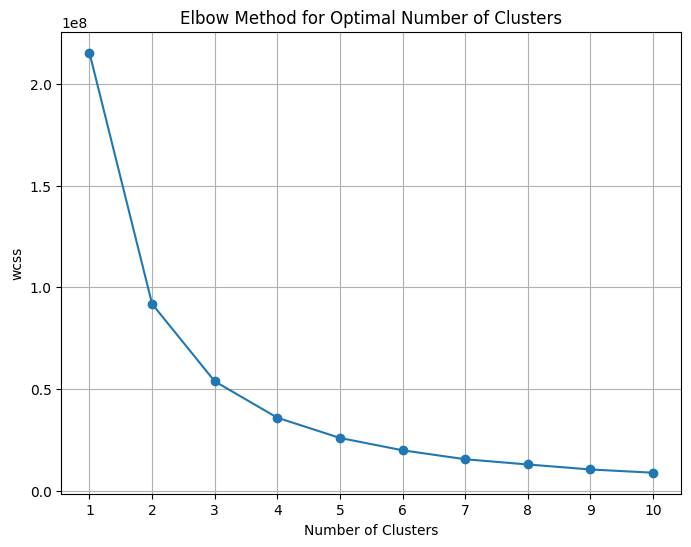

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [82]:
from kneed import KneeLocator

kl = KneeLocator(k_range,wcss,curve='convex',direction='decreasing')
kl.elbow

3

In [83]:
num_clusters = 3  

kmeans = KMeans(n_clusters=num_clusters, random_state=42)

kmeans.fit(combined_feature)

data['cluster'] = kmeans.labels_


In [84]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_condition,cleaned_review,cluster
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,left ventricular dysfunction,side effect take combination bystolic 5 mg fis...,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,adhd,son halfway fourth week intuniv became concern...,0
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,birth control,used take another oral contraceptive 21 pill c...,1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,birth control,first time using form birth control 039 glad w...,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,opiate dependence,suboxone completely turned life around feel he...,2


In [52]:
pip install -U textblob

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the review column
data['sentiment'] = data['cleaned_review'].apply(get_sentiment)




In [89]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_condition,cleaned_review,cluster,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,left ventricular dysfunction,side effect take combination bystolic 5 mg fis...,1,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,adhd,son halfway fourth week intuniv became concern...,0,0.148611
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,birth control,used take another oral contraceptive 21 pill c...,1,0.119805
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,birth control,first time using form birth control 039 glad w...,1,0.262500
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,opiate dependence,suboxone completely turned life around feel he...,2,0.194444


In [108]:
condition = input("Enter condition: ")

filtered_df = data[data['cleaned_condition'].str.lower() == condition.lower()]

if not filtered_df.empty:
    recommended = filtered_df.sort_values(by='sentiment', ascending=False)
    top_recommendations = recommended[['drugName', 'sentiment']].head(5)  
    print("Recommended Drugs:")
    print(top_recommendations)
else:
    print("No drugs found for the specified condition.")

Recommended Drugs:
                        drugName  sentiment
145381             Buprenorphine        1.0
49328                   Suboxone        1.0
69317                    Subutex        1.0
67323   Buprenorphine / naloxone        1.0
65430                   Suboxone        1.0


In [109]:
from sklearn.metrics.pairwise import cosine_similarity


In [112]:
def clean_condition(condition):
    return clean_review(condition)

def recommend_drugs(condition):
    cleaned_condition = clean_condition(condition)  
    filtered_df = data[data['cleaned_condition'].str.lower() == cleaned_condition.lower()]

    if not filtered_df.empty:
        # Calculate cosine similarity based on sentiment
        similarity_matrix = cosine_similarity(filtered_df[['sentiment']])
        similarity_df = pd.DataFrame(similarity_matrix, index=filtered_df.index, columns=filtered_df.index)

        # Sort drugs by similarity and sentiment
        recommended_indices = similarity_df.sum(axis=1).sort_values(ascending=False).index
        top_recommendations = filtered_df.loc[recommended_indices].head(3)[['drugName', 'sentiment']]
        
        print("Recommended Drugs:")
        print(top_recommendations)
    else:
        print("No drugs found for the specified condition.")

# Example of how to use the recommendation function
condition_input = input("Enter condition: ")
recommend_drugs(condition_input)

Recommended Drugs:
             drugName  sentiment
2              Lybrel   0.119805
94534  Levonorgestrel   0.095578
94521           Beyaz   0.250000
